# Meta Edge Prediction


Virtual envorinemnt - 
source .venv/bin/activate





Final project for Biological Networks, CSCI 3352

Be a lil sloppy that's ok. Get it done first, refine, comment, cleanup, later

Things we might wanna do:
- Dig into the data more, see why diff models work better than others


### Summary of Project

Write this at the end as our project may change as we go... 

Don't forget to fill in the comments in each of the sections!

Have instrucitons for importing the data and stuff



### Citations

Refine this aswell....

@article{ghasemian2020stacking,
  title = {Stacking models for nearly optimal link prediction in complex networks},
  author = {Ghasemian, Amir and Hosseinmardi, Homa and Galstyan, Aram and Airoldi, Edoardo M and Clauset, Aaron},
  journal = {Proceedings of the National Academy of Sciences},
  volume = {117},
  number = {38},
  pages = {23393--23400},
  year = {2020},
  publisher = {National Acad Sciences},
}

In [1]:
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split

from concurrent.futures import ProcessPoolExecutor

import copy

# Importing Data

In [2]:
import pickle  

def import_data():
    # Load the data
    infile = open('./01-network-data/OLP_updated.pickle','rb')
    df = pickle.load(infile)

    # Filter df to get biological networks with > 200 nodes
    df_bio_200_nodes = df[(df['networkDomain'] == 'Biological') & (df['number_nodes'] > 200)]

    ####### Convert the data (dataframe format) into networ-x graphs #######

    # Only grab graphs from these subDomains
    subDomains = ['Metabolic', 'Protein interactions', 'Tissue']

    # Place to store the nx-graphs of each subDomain
    Gs_subDomains = [] 

    for subDomain in subDomains:
        
        # Isolate df-graphs of this subDomain
        df_subDomain = df_bio_200_nodes[(df_bio_200_nodes['subDomain'] == subDomain)]
        
        Gs_subDomain = [] # Place to store nx-graphs of a subDomain
        
        # On each df-graph, convert it to a nx-graph and store
        for i in range(len(df_subDomain)):
            
            # Get list-edges from df-graph
            df_subDomain_single_G = df_subDomain['edges_id'].iloc[i] 
            
            # Place to store tuple-edges
            G_tuple_list = [] 
            
            # Convert df edges into tuples
            for x in df_subDomain_single_G:
                G_tuple_list.append(tuple(x))
                
            # Convert the tuple list to a nx-graph
            G_nx = nx.from_edgelist(G_tuple_list)
                
            # Add the nx-graph to Gs_metabolic
            Gs_subDomain.append(G_nx) 
            
        Gs_subDomains.append(Gs_subDomain)

    return Gs_subDomains

Gs_subDomains = import_data()


Network subDomain: Metabolic
# of graphs: 26
Avg number of nodes, n  = 673.0384615384615
Avg number of edges, m  = 1648.923076923077
Avg mean degree,    <k> =  4.88
Avg clustering coefficient, C     =  0.05
Sample rediculograms of subDomain: Metabolic


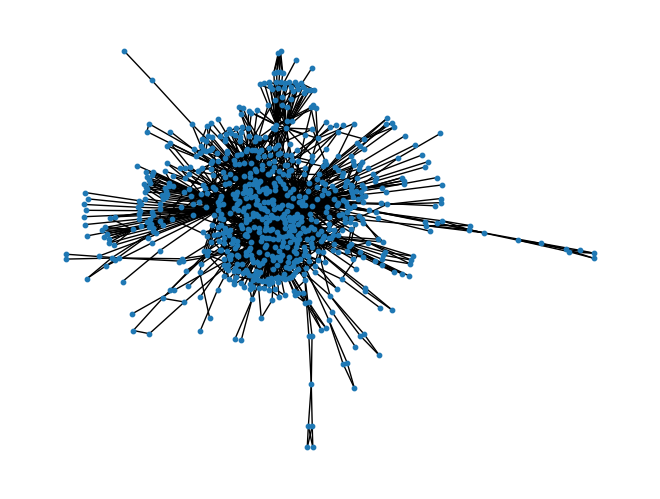

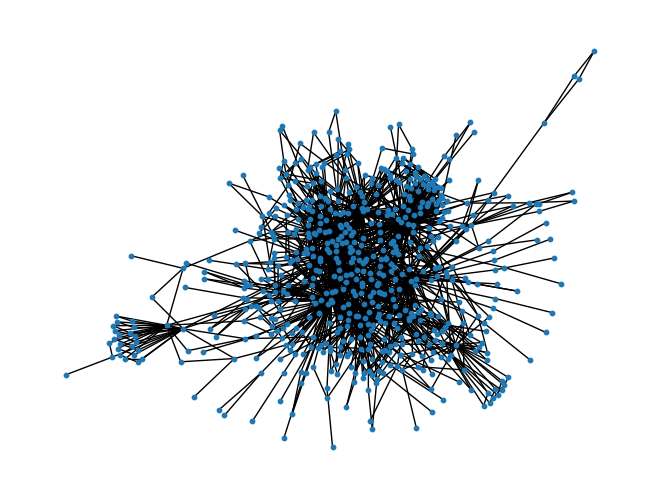



Network subDomain: Protein interactions
# of graphs: 20
Avg number of nodes, n  = 882.35
Avg number of edges, m  = 1797.5
Avg mean degree,    <k> =  5.46
Avg clustering coefficient, C     =  0.10
Sample rediculograms of subDomain: Protein interactions


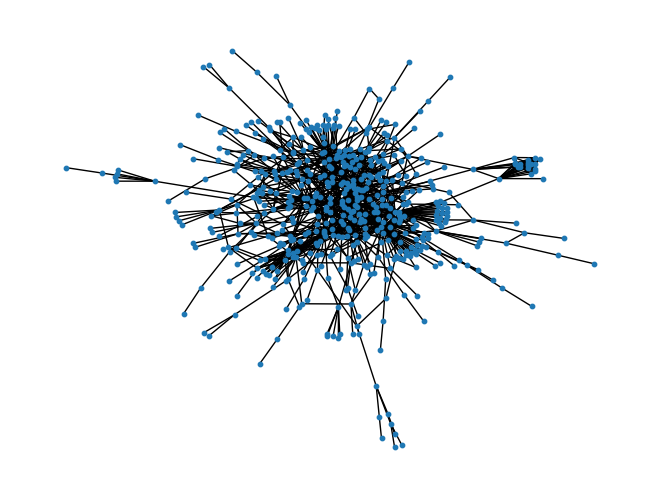

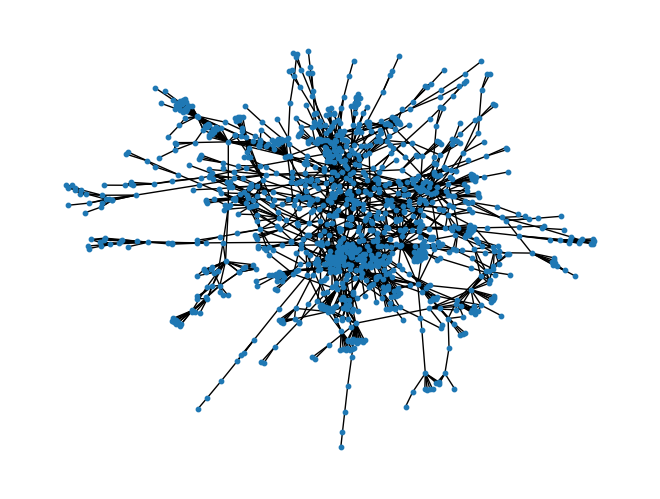



Network subDomain: Tissue
# of graphs: 18
Avg number of nodes, n  = 305.94444444444446
Avg number of edges, m  = 403.72222222222223
Avg mean degree,    <k> =  2.66
Avg clustering coefficient, C     =  0.11
Sample rediculograms of subDomain: Tissue


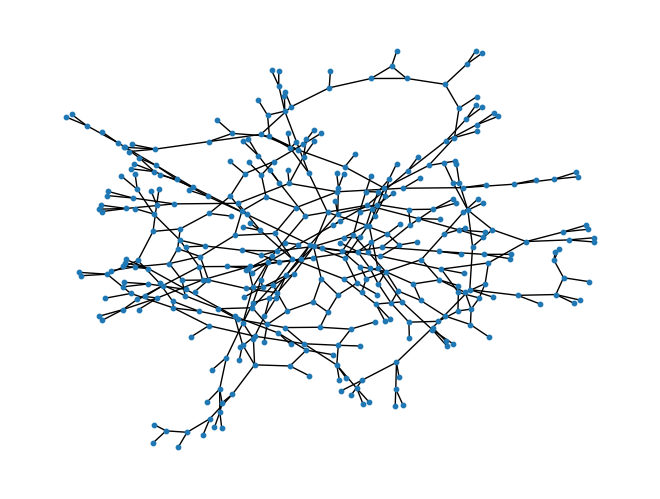

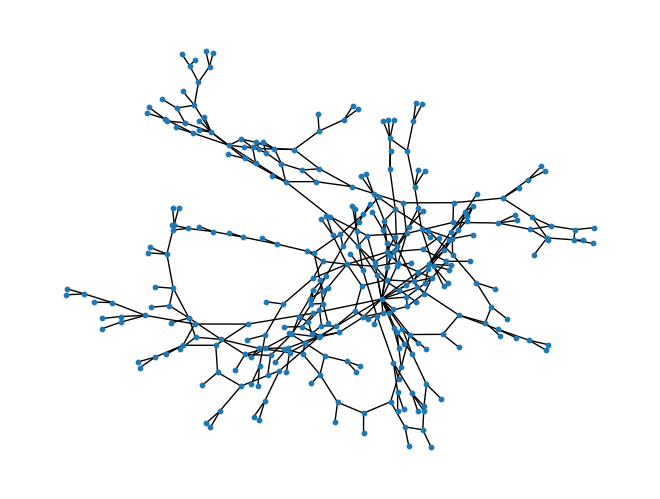

In [3]:
# # Print stats on the data


# # # MGD function from homework 4
# # def compute_MGD(G):
# #     # input : a networkx graph G
# #     # output: the mean geodesic path length (defined in Lecture 2)

# #     # YOUR CODE HERE
    
# #     shortest_paths_data = list(nx.all_pairs_shortest_path_length(G)) # Get data of all shortest paths
# #     shortest_paths = []
# #     for i in shortest_paths_data: # Iterate through each node in the array/dict data
# #         for j in i[1].values(): # Isolate the geodesics for this node
# #             if j != 0 and j != np.inf: # Ensure geodesic is not 0 or infinity
# #                 shortest_paths.append(j)
                
# #     if len(shortest_paths) == 0: # If empty graph, return geodesic dist of inf.
# #         return float('inf') # It needs to returns somehting if no edges, or else we get a divide by zero error
# #     else: 
# #         MGD = sum(shortest_paths) / len(shortest_paths) # Calculate MGD from shortest paths
# #         return MGD





subDomains = ['Metabolic', 'Protein interactions', 'Tissue']


for i in range(len(Gs_subDomains)): # On each subDomain print...
    
    Gs = Gs_subDomains[i] # Graphs of current subDomain
    
    print('Network subDomain:', subDomains[i])
    
    graph_count = len(Gs)
    print('# of graphs:', graph_count)
    
    avg_n = np.mean([len(G.nodes) for G in Gs])
    print(f'Avg number of nodes, n  = {avg_n}')
    
    avg_m = np.mean([len(G.edges) for G in Gs])
    print(f'Avg number of edges, m  = {avg_m}')

    kmeans = []
    for G in Gs:
        kmeans.append(2 * G.number_of_edges() / G.number_of_nodes())
    avg_kmeans = np.mean(kmeans)
    print(f'Avg mean degree,    <k> = %5.2f' % avg_kmeans)
    
    avg_C = np.mean([nx.transitivity(G) for G in Gs])
    print(f'Avg clustering coefficient, C     = %5.2f' % avg_C)
    
    # avg_ellmean = np.mean([compute_MGD(G) for G in Gs]) 
    # print(f'Avg mean geodesic distance, <ell> = %5.2f' % avg_ellmean)
    
    print('Sample rediculograms of subDomain:', subDomains[i])
    g1, g2 = np.random.choice(range(graph_count), 2, replace=False) # Randomly pick 2 graphs to display    
    nx.draw_spring(Gs[g1], node_size=10) # Rediculogram of a graph
    plt.show()
    nx.draw_spring(Gs[g2], node_size=10) # Rediculogram of a graph
    plt.show()
    
    print('\n') # Space out different subDomains
    
    

# Run Edge Prediction on Graphs

Some cool description stuff abt this section maybe idk

In [4]:
# Make G-Observerd and G-Missing


def seperate_Go_Gmissing(Gs, alpha):
    # IMPORTANT!!!
    # Now instead of being a graph, the nodes and edges will be represented as a list
    edges_o = [] # G-Observed
    edges_missing = [] # G-Missing
    nodes = []

    for G in Gs:
        G_nodes = []
        for node in G.nodes():
            G_nodes.append(node)
        nodes.append(G_nodes)
        
        edge_o = []
        edge_missing = []
        for edge in G.edges():
            if alpha > np.random.rand():
                edge_o.append(edge)
            else:
                edge_missing.append(edge)
        edges_o.append(edge_o)
        edges_missing.append(edge_missing)

        
        
        
    # Convert the edges into graphs
    Gs_o = []
    Gs_missing = []

    for e_o, e_missing in zip(edges_o, edges_missing):
        
        # Create the graphs
        G_o = nx.Graph()
        G_missing = nx.Graph()
        
        # Add edges to graphs
        G_o.add_edges_from(e_o)
        G_missing.add_edges_from(e_missing)
        
        # Add graphs to array of graphs
        Gs_o.append(G_o)
        Gs_missing.append(G_missing)

    # print('Edges observed', len(edges_o[g]))
    # print('Edges missing', len(edges_missing[g]))
    # print("Example edge from edges_o:", edges_o[g][4])
    return Gs_o, Gs_missing
    

# !!!!!!!!!!!
# To start, just do everything on the subDomain: metabolic
Gs = Gs_subDomains[0]

seed = 630
alpha = 0.9 # Number of edges to observe
Gs_o, Gs_missing = seperate_Go_Gmissing(Gs, alpha)


    
    
# Sanity check
g = 3
print(Gs[g])
print('G missing:', Gs_missing[g])

Graph with 619 nodes and 1501 edges
G missing: Graph with 184 nodes and 139 edges


# Get Lists of edge/nonedge Data

This data tells for each potential new edge, if it was actually a nonedge, it will have a 0, if it was actually an edge, it will have a 1

In [5]:
def create_edgenonedge_data(G_o, G_missing):
    
    data = []
    
    for u, v in nx.non_edges(G_o):
        if G_missing.has_edge(u,v):
            data.append(1)
        else:
            data.append(0)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(data).reshape(-1, 1)



def create_edgenonedge_data_ALL(Gs_o, Gs_missing):
    edgenonedge_data = [] # Place to store predictions

    for G_o, G_missing in zip(Gs_o, Gs_missing): # Create edgenonedge_data on each graph
        d = create_edgenonedge_data(G_o, G_missing)
        edgenonedge_data.append(d)
    return edgenonedge_data

edgenonedge_data = create_edgenonedge_data_ALL(Gs_o, Gs_missing)

print(edgenonedge_data[2].shape)

(291307, 1)


In [6]:
# Save data for later use

# Save data 
with open('04-edgenonedge-data/edgenonedge_data.pkl', 'wb') as f:
    pickle.dump(edgenonedge_data, f)


## Run predictors on the graphs

In [7]:
# Run jaccard edge predictor on graphs

# Function to compute edge predictions on all edges in a single graph
def predictor_jaccard(G_o):

    # Compute predictor scores
    predictions = dict(((u, v), p) for u, v, p in nx.jaccard_coefficient(G_o))
    
    ordered_predictions = []

    # Grab predictor scores in the same order as the other predictor functions
    for u, v in nx.non_edges(G_o):
        p = predictions.get((u, v))
        ordered_predictions.append(p)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(ordered_predictions).reshape(-1, 1)

In [8]:
# Run adamic-adar edge predictor on graphs

# Function to compute edge predictions on all edges in a single graph
def predictor_adamic_adar(G_o):

    # Compute predictor scores
    predictions = dict(((u, v), p) for u, v, p in nx.adamic_adar_index(G_o))
    
    ordered_predictions = []

    # Grab predictor scores in the same order as the other predictor functions
    for u, v in nx.non_edges(G_o):
        p = predictions.get((u, v))
        ordered_predictions.append(p)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(ordered_predictions).reshape(-1, 1)

In [9]:
# Run geodesic edge predictor on graphs

# Function to compute edge predictions on all edges in a single graph
def predictor_geodesic(G_o):
    
    predictions = []
    
    for u, v in nx.non_edges(G_o):
        try:
            score = nx.shortest_path_length(G_o, u, v)
            predictions.append(score)
        except nx.NetworkXNoPath: 
            # No path - set score to 0
            predictions.append(0)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(predictions).reshape(-1, 1)

In [10]:
# Run common-neighbors edge predictor on graphs

# Function to compute edge predictions on all edges in a single graph
def predictor_common_neighbors(G_o):
    
    predictions = []
    
    for u, v in nx.non_edges(G_o):
        score = len(list(nx.common_neighbors(G_o, u, v)))
        predictions.append(score)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(predictions).reshape(-1, 1)

In [11]:
# Run degree-product edge predictor on graphs

# Function to compute edge predictions on all edges in a single graph
def predictor_degree_prod(G_o):
    
    predictions = []
    
    for u, v in nx.non_edges(G_o):
        score = G_o.degree[u] * G_o.degree[v]
        predictions.append(score)
        
    # Convert to NumPy array and reshape to (N, 1)
    return np.array(predictions).reshape(-1, 1)

degree_prod_edge_scores = [] # Place to store predictions

for G_o in Gs_o: # Make predictions on each graph
    p = predictor_degree_prod(G_o)
    degree_prod_edge_scores.append(p)

In [12]:
# # Predict missing edges with baseline predictor (random)

# baseline_edge_scores = [] # Place to store predictions

# for G in jacc_edge_scores:
#     predictions = []
#     for edge in G:
#         predictions.append(np.random.uniform(0,1))
#     baseline_edge_scores.append(np.array(predictions).reshape(-1, 1))
    
    
    

In [13]:
def run_predictors(Gs_o):

    jacc_edge_scores = [] # Place to store predictions
    for G_o in Gs_o: # Make predictions on each graph
        p = predictor_jaccard(G_o)
        jacc_edge_scores.append(p)

    adamic_adar_edge_scores = [] # Place to store predictions
    for G_o in Gs_o: # Make predictions on each graph
        p = predictor_adamic_adar(G_o)
        adamic_adar_edge_scores.append(p)

    geodesic_edge_scores = [] # Place to store predictions
    for G_o in Gs_o: # Make predictions on each graph
        p = predictor_geodesic(G_o)
        geodesic_edge_scores.append(p)

    common_neighbors_edge_scores = [] # Place to store predictions
    for G_o in Gs_o: # Make predictions on each graph
        p = predictor_common_neighbors(G_o)
        common_neighbors_edge_scores.append(p)

    degree_prod_edge_scores = [] # Place to store predictions
    for G_o in Gs_o: # Make predictions on each graph
        p = predictor_degree_prod(G_o)
        degree_prod_edge_scores.append(p)

    baseline_edge_scores = [] # Place to store predictions
    for G in jacc_edge_scores:
        predictions = []
        for edge in G:
            predictions.append(np.random.uniform(0,1))
        baseline_edge_scores.append(np.array(predictions).reshape(-1, 1))

    predictors = copy.deepcopy([jacc_edge_scores, adamic_adar_edge_scores, geodesic_edge_scores, 
              common_neighbors_edge_scores, degree_prod_edge_scores, 
             baseline_edge_scores])
    
    return predictors
    

predictors = run_predictors(Gs_o)

## Sanity Check!

Im scared lol

## Save The Predictions

Whew those predictions take forever to calculate. Lets save them so we don't have to run this code everytime!

In [14]:
# predictors = copy.deepcopy([jacc_edge_scores, adamic_adar_edge_scores, geodesic_edge_scores, 
#               common_neighbors_edge_scores, degree_prod_edge_scores, 
#              baseline_edge_scores])

# Save data 
with open('02-predictor-data/raw/predictors.pkl', 'wb') as f:
    pickle.dump(predictors, f)


# Get edge metadata

In [15]:
import networkx as nx
import numpy as np


# Takes my laptop ~40 sec to run

def create_edge_metadata(G_o, G_p):
    data = []
    
    # Precompute graph-level metadata
    node_count = G_o.number_of_nodes()
    edge_count = G_o.number_of_edges()
    density = nx.density(G_o)
    avg_degree = sum(dict(G_o.degree()).values()) / node_count
    clustering_coeff = nx.average_clustering(G_o)
    jacc_edge_scores = G_p[0]
    adamic_adar_edge_scores = G_p[1]
    geodesic_edge_scores = G_p[2]
    common_neighbors_edge_scores = G_p[3]
    degree_prod_edge_scores = G_p[4]
    
    try:
        diameter = nx.diameter(G_o) if nx.is_connected(G_o) else -1  # Use -1 for disconnected graphs
    except nx.NetworkXError:
        diameter = -1  # Handle cases where diameter cannot be computed
    
    num_connected_components = nx.number_connected_components(G_o)
    
    # Precompute node-level metadata
    degrees = dict(G_o.degree())
    pagerank = nx.pagerank(G_o)
    
    # Iterate over non-edges and compute edge metadata
    i = 0
    for u, v in nx.non_edges(G_o):  # Order maintained by nx.non_edges()
        # if i%100000 == 0:
        #     print('Completed the', i,'th iteration')
        # Edge-specific metadata
        degree_u = degrees.get(u, 0)
        degree_v = degrees.get(v, 0)
        pagerank_u = pagerank.get(u, 0)
        pagerank_v = pagerank.get(v, 0)
        
        # Combine edge and graph metadata
        edge_entry = [
            degree_u, degree_v,       # Node degrees
            pagerank_u, pagerank_v,   # Node PageRank
            node_count, edge_count,   # Graph size
            density, avg_degree,      # Graph density and avg degree
            diameter,                 # Graph diameter
            num_connected_components, # Number of connected components
            clustering_coeff,         # Avg clustering coefficient
            jacc_edge_scores[i].item(), adamic_adar_edge_scores[i].item(),
            geodesic_edge_scores[i].item(), common_neighbors_edge_scores[i].item(),
            degree_prod_edge_scores[i].item()

        ]
        data.append(edge_entry)
        i += 1

    # Convert to NumPy array
    return np.array(data)

def create_edge_metadata_ALL(Gs_o, predictors):
    # Example usage:
    edge_metadata = []  # Place to store metadata arrays

    for i in range(len(Gs_o)):  # Create edge metadata for each graph in Gs_o
        G_o = Gs_o[i]
        G_p = [] # Place to store predictor data for this graph
        for p in predictors: # Over each predictor
            G_p.append(p[i]) # Get this graphs predictor data
        d = create_edge_metadata(G_o, G_p)
        # print('Sample predictor score for a graph:', G_p[0][0].item())

        edge_metadata.append(d)
    return edge_metadata



edge_metadata = create_edge_metadata_ALL(Gs_o, predictors)

In [16]:
# Save data for later use

# Takes ~

# Save data 
with open('05-edge-metadata/edge_metadata.pkl', 'wb') as f:
    pickle.dump(edge_metadata, f)